# An Introduction to Hedging: Liability-Driven Investment

By definition, any financial entity has both assets and liabilities on their balance sheet. Therefore, it is rational to build an investment stratgy that considers both of these sides. It is true that generating positive returns and growing the asset side of the balance sheet always seems attractive. However, returns come at the cost of taking risk, and one's ability to take risk is influenced by the structure of their liabilities. This is where the concept of hedging emerges where the goal of financial management is not to drive the value of our assets as high as possible; it's rather to maintain the ability to meet financial needs. 

Hedging, in essence, is an insurance policy against negative financial shocks; whether due to an unexpected fall in realized returns, or through an unexpected increase in liabilities due to a change in the interest rate. Hedging is a  complex subject that involves the use of various financial instruments to offset risks. `Hedging` is different from the concept of `diversification`. Although, diversification provides some protection against risks associated with individual assets in the portfolio, hedging is concerned with the investor's ability to pay its debt; *i.e.,* the ratio of assets to liabilities. This is specially important as diversification is not effective against *systemic risks*.

In this notebook, I briefly review the concept of hedging through a series of simulation exercises. My focus will mostly be on the evolution of `interest-bearing liabilities`, and will **NOT** discuss hedging through derivatives. 

## Table of Contents

[1. Interest Rate Risk](#1) 
- [Short-Term Interest Rate Fluctuations: Cox-Ingersoll-Ross Model](#1.1)
- [Evolution of Liabilities](#1.2)
- [Funding Ratio and the Interest Rate Risk](#1.3)

[2. Liability-Driven Investment ](#2) 
- [Performance Seeking Portfolio (PSP) vs. Liability Hedging Portfolio (LHP)](#2.1)
- [Duration-Matching Bond Portfolios](#2.2)
    * [Duration-matching Bond Portfolio: Another Look](#2.2.1)
- [Asset Allocation: A Simulation](#2.3)
    * [Coupon-Bearing Bonds ](#2.3.1)
    * [PSP vs. LHP Allocation](#2.3.2)



In [274]:
import math
import ipywidgets
import pandas as pd
import numpy as np
import risk_mod as rm
import seaborn as sns
import Portfolio_mod as pm
import matplotlib.pyplot as plt
from ipywidgets import Layout

## Interest Rate Risk <a id="1"></a>

There are various types of financial risk against which investors should protect themselves. Those types of risks include, but are not limited to, *equity risk*, *currency risk*, and *volatility risk*. In this notebook, I study the imapct of **interest rate risk**. This risk involves an unexpected rise in the value of an interest-bearing liability, such as a loan or a bond, due to an interest rate fall. This may seem counter-intuitive. So, I start by demonstrating this relationship through a basic example. 

The following function computes the present value of a series object given an interest rate.  

In [2]:
def present_value(seq, r):
    """
    Computes the present value of a series 
    Inputs
        seq : a time-indexed vector of values; e.g., liabilities indexed with their time to maturity (ttm)
        r   : interest rate as a scalar
    Output
        present value of the series
    """
    disc_rate = (1+r)**(-1.0 * seq.index)              # a vector of discount rate

    return (disc_rate * seq).sum()

Consider the following seqeunce of liabilities with TTM in years

$$
\begin{cases}
Values &= [1.0, 1.5, 2.0, 2.5]\\
TTM    &= [3.0, 3.5, 4.0, 4.5] 
\end{cases}
$$


The present value of the liabilities based on an interest rate of `3 percent` per year is:


In [8]:
# An example:
liab = pd.Series(data=[1.0, 1.5, 2.0, 2.5], index=[3.0, 3.5, 4.0, 4.5])

present_value(liab, 0.03)

6.233320315080045

Now, consider a change in the interest rate:

In [17]:
print("Interest Rate Risk by Example:")
print("---------------------------------------------------------------")
print("r = 0.05 -------> Present Value of Liabilities = ", present_value(liab , 0.05).round(4))
print("r = 0.04 -------> Present Value of Liabilities = ", present_value(liab , 0.04).round(4))
print("r = 0.03 -------> Present Value of Liabilities = ", present_value(liab , 0.03).round(4))
print("r = 0.02 -------> Present Value of Liabilities = ", present_value(liab , 0.02).round(4))
print("r = 0.01 -------> Present Value of Liabilities = ", present_value(liab , 0.01).round(4))
print("")

Interest Rate Risk by Example:
---------------------------------------------------------------
r = 0.05 -------> Present Value of Liabilities =  5.781
r = 0.04 -------> Present Value of Liabilities =  6.0017
r = 0.03 -------> Present Value of Liabilities =  6.2333
r = 0.02 -------> Present Value of Liabilities =  6.4764
r = 0.01 -------> Present Value of Liabilities =  6.7317



This example shows that any decrease in the interest rate would worsen our financial situation as it increases the present value of our liabilities. Add to this, the fact that a decrease in the interest rate could be in response to an adverse shock to the economy, which may have already negatively impacted the asset side of our balance sheet. A combination of both these effects could certainly jeopordize our ability to meet our financial needs even if our assets were initially enough to repay our debt. This is shows the nature of the interest rate risk. 

In addition to that, the above example demonstrates why the dynamics of the interest rate are important. We normally understand the interest rate as an annual rate. For instance, if I borrow 100 USD at 10 percent, I am expected to repay 110 USD next year. However, the truth is that the interest is applicable in every second of the debt period. In other words, if I borrow money and decide to repay my debt one second later, I owe my lender the principal of my debt and the interest for that one second. Therefore, if I keep my debt, from the second moment onward, my debt should actually grows. This is because, from the second moment, in effect, my principal is the actual principal plus the interest that I owe in the first moment. This notion of `compounding` is a key to understand `Short Term Interest Rates`. So, let's further examine this notion through an example. Let's assume that the principal of the debt is 1 unit and the anuual interest rate is 100 percent:


* If the interest rate is applied only once (one payment):

$$ 1 + 1*1 = 2$$

* If the interest rate is applied twice (two payments): In six months, the borrower is supposed to repay the principal and half of the annual rate, which is $0.5$. For the second half of the year, the borrower should pay the remaining interest rate $0.5$ on the total debt which is the principal as well as the interest on the first interest payment. 

$$ 1 + 1*0.5 + (1 + 1*0.5)*0.5= 2.25$$

* If the interest rate is applied four times:

$$1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25)*.25 = 2.44$$

* In general, if we compound every 1/N of a year (i.e. N times a year):

$$\left(1+\frac{r}{N}\right)^N $$

Since time is continuous, we can take the limits of this ratio as $N \rightarrow \infty$

$$\left(1+\frac{r}{N}\right)^N \hspace{2mm} \rightarrow \hspace{2mm} e^r$$

Therefore, given the effect of compounding, if the short-term rate is given by $r$, 

$$ r_{annual} = \left(1+\frac{r_{inst}}{N}\right)^N - 1 \approx e^{r_{inst}} - 1$$

or, equivalently

$$r_{inst} = \ln(1+r_{annual})$$

where

   * $r_{inst}$ is the instantaneous interest rate,
   * $r_{annual}$ is the annual interest rate


### Short-Term Interest Rate Fluctuations: Cox-Ingersoll-Ross Model <a id="1.1"></a>

Considering the critical role of instantaneous rates in risk hedging, the literature has developed various model to study its evolution over time. These models basically regard the short-term rate as similar to risky assets with certain properties. In this notebook, I use the `Cox-Ingersoll-Ross (CIR)` model (1985). This models imposes a mean-reverting mathematical equation on the fluctuations of the short-term interest rate fluctuations. These fluctuations, $dr_{t}$, are assumed to be a function of the speed of mean reversion as well as the long term average rate:

$$ dr_{t}=a(\bar{r}-r_{t})dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where 
  * $a$ is the speed of mean reversion.
  * $\bar{r}$ is the long term mean rate. 
  * $\sigma$ is the volatility parameter.

In other words, the short-term changes are assumed to have two components. The first component is a determinstic term that essentially returns the short-term rate to its long-term average. The second term is a stochastic component that causes random movements in the short-term rate. 

We should note that the term ${\sqrt  {r_{t}}}$ in the stochastic component is bascially a scaling parameter that ensures the short-term rate never takes a negative value. This is becuase as the short-term rate approaches zero, the size of the stochastic component shrinks. Therefore, near zero, the change in the rate is almost entirely determined by the deterministic factor, which is mean-reverting. 

The following code is an implementation of the CIR model:

In [3]:
def cir(sim_length, n_paths, a, rbar, sigma, freq):
    
    """
    Simulates the evolution of the short-term interest rate according to CIR model
    
    Inputs
        sim_length : length of simulation in years
        n_paths    : number of simulated paths
        a          : mean-reversion speed
        rbar       : average long-term annualized rate
        sigma      : volatility of short term rate
        freq       : frequency of shocks in a year
    
    output
        Simulated paths for "instantenous", "annualized" rates as dataframes
    
    """

    dt       = 1/freq                             # time interval between shocks
    n_shocks = int(sim_length * freq) + 1         # number of shocks on each path
    
    # dataframe of simulated rates
    ins_rate = pd.DataFrame(columns = range(n_paths), index = range(n_shocks))      # instantenous rates
    ann_rate = pd.DataFrame(columns = range(n_paths), index = range(n_shocks))      # annualized rates
    
    
    ins_rate.iloc[0] = np.log(1.0 + rbar)      # start from the instantenous equivalent of the long-run annualized rate
    ann_rate.iloc[0] = rbar
    
    
    for period in range(1, n_shocks):
        
        r_past = ins_rate.iloc[period-1]
        dw_t   = np.random.normal(0, scale = np.sqrt(dt), size = n_paths)
        dr_t   = a * (rbar - r_past) * dt + sigma * (np.sqrt(r_past.astype('float64'))) * dw_t
        
        ins_rate.iloc[period] = abs(r_past + dr_t)
    
    ann_rate = np.exp(ins_rate.astype('float')) - 1.0
     
    return ann_rate, ins_rate 


In [4]:
freq       = 12
sim_length = 10
n_paths    = 10
a          = 0.05
rbar       = 0.03
sigma      = 0.05

annual_r, inst_r = cir(sim_length, n_paths, a, rbar, sigma, freq)

### Evolution of Liabilities  <a id="1.2"></a>

After simulating the short-term interest rate, now, in this section, I study the evolution of (a sequence of) liabilities as implied by the simulated interest rates. For this purpose, first, I am going to simulate random paths for the price of a zero-coupon bond. A Zero-Coupon (ZC) bond, as its name suggests, pays no interests before its and pays the full face value at the time of maturity.


Therefore, the price of zero-coupon bond with maturity $T$ at time $t$ is given by  

$$P(t,T)= e^{-(t-T)r}$$

where $r$ is the **constant** interest rate.

This formulation prices a ZC bond based on the present value of its face value at the time of maturity. As a result of this logic: 

   * $t << T \hspace{2mm}: \hspace{2mm} P(0,T) = e^{r_{inst}T} = (1+r_{annual})^T$

   * $t \rightarrow T \hspace{4mm}: \hspace{2mm} P(T,T) = 1$


However, we are dealing with *stochastic* and time-dependent short-term rate. Thus, 

$$P(t,T)= \mathbb{E} \bigg[e^{(-\int_{t}^{T}r(s)ds)}\big|\mathcal{I}_t\bigg]$$


Financial mathematicians have shown that if the short-term rate evolves according to the CIR model, then we can derive the price of a zero-coupon bond as 

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)(T-t)/2}}{2h+(a+h)(e^{(T-t) h}-1)}}\right)^{{2a\bar{r}/\sigma ^{2}}} $$

and

$$ B(t,T)={\frac  {2(e^{(T-t) h}-1)}{2h+(a+h)(e^{(T-t) h}-1)}} $$

and

$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$

I use this formulation to simulate the price of a ZC bond.

In [4]:
def zcbp(sim_length, n_paths, a, rbar, sigma, freq, plots = 'ON'):
    """
    Computes and plots price of ZC bond under different scenarios according to CIR the model
    
    Inputs
        sim_length : length of simulation in years
        n_paths    : number of simulated paths
        a          : mean-reversion speed
        rbar       : average long-term annualized rate
        sigma      : volatility of short term rate
        freq       : frequency of shocks in a year
    
    output
        Simulated paths for "annualized" rates as a dataframe
        Simulated paths for price of a zero-coupon bond as a dataframe  
    """
    annual_r, inst_r = cir(sim_length, n_paths, a, rbar, sigma, freq)  # simulate paths for interest rate
    
    # price simulation
    
    h = np.sqrt(a**2 + 2*sigma**2)
    def price_sim(ttm, r):
        """
        computes price of a zero-coupon bond
        Inputs
            ttm   : time-to-maturity (ttm)
            r     : the interest rate
            
        Output
            price
        """      
        A = ((2*h*np.exp((h+a)*ttm/2))/(2*h+(h+a)*(np.exp(h*ttm)-1)))**(2*a*rbar/sigma**2)
        B = (2*(np.exp(h*ttm)-1))/(2*h + (h+a)*(np.exp(h*ttm)-1))
        P = A*np.exp(-B*r)
        return P
    
    dt        = 1/freq                                     # time interval between shocks  
    n_shocks  = int(sim_length * freq) + 1                 # number of shocks on each path
    
    zcb_price = pd.DataFrame().reindex_like(annual_r)      # Dataframe for storing prices                 
   
    for period in range(n_shocks):
        zcb_price.iloc[period] = price_sim(sim_length - period * dt, annual_r.iloc[period])
    
    if plots != "OFF":
         # plots
        tag = "Simulated Annualized Rates According to CIR Model (" + str(n_paths) + " paths)" 
        annual_r.plot(legend = False, figsize = (11,5), title = tag)

        tag = "Simulated Prices of a ZC Bond According to CIR Model (" + str(n_paths) + " paths)"
        zcb_price.plot(legend = False, figsize = (11,5), title = tag)
   
    return zcb_price


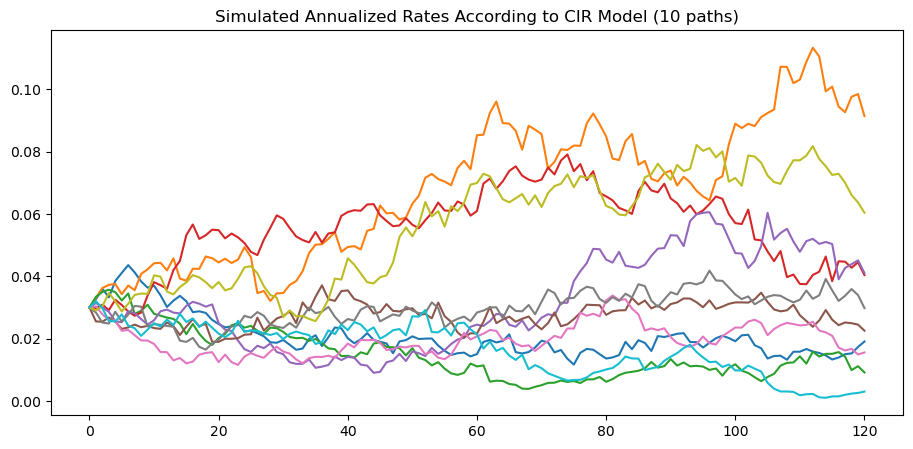

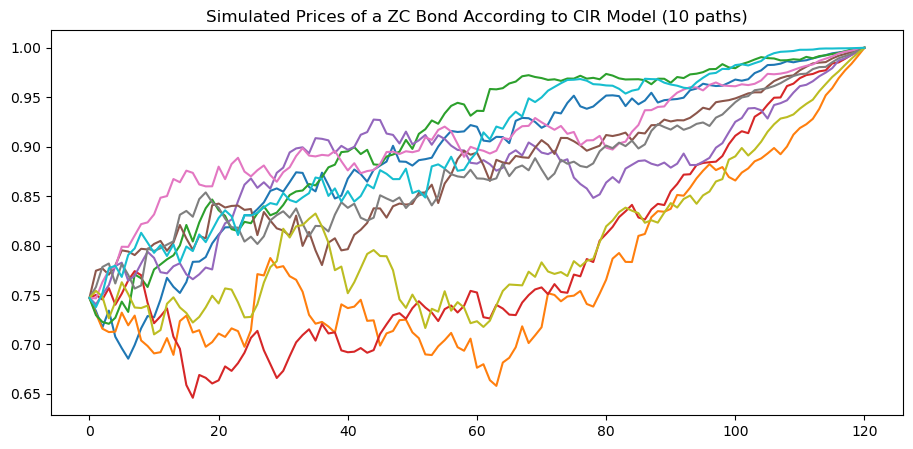

In [8]:
freq       = 12
sim_length = 10
n_paths    = 10
a          = 0.05
rbar       = 0.03
sigma      = 0.05

zc_p = zcbp(sim_length, n_paths, a, rbar, sigma, freq)

In [14]:
zcb_int = ipywidgets.interactive(zcbp,
                                 sim_length  = (1.00, 12.00, 1),
                                 n_paths     = (1, 500, 50),
                                 a           = (0.0, 0.6, 0.02),
                                 rbar        = (0.0, 0.06, 0.01),
                                 sigma       = (0.0, 0.10, 0.01),
                                 freq        = ipywidgets.fixed(12),
                                 plots       = ipywidgets.RadioButtons(options     = ['ON', 'OFF'],
                                                                     description = 'Plots', 
                                                                     disabled    = False)
                                 )
display(zcb_int)

interactive(children=(FloatSlider(value=6.0, description='sim_length', max=12.0, min=1.0, step=1.0), IntSlider…

###  Funding Ratio and the Interest Rate Risk <a id="1.3"></a>

The funding ratio is defined as the ratio between the value of assets and the value of the liabilities. This ratio, in essence, reflects the current financial position of an entity. In this section, I want to simulate the evolution of the funding ratio considering various scenarios. The present value of a sequence of liabilities $L$ is give by:

$$ PV(L) = \sum_{i=1}^{k}  \frac{1}{(1+r)^{t_i}} L_i$$

where liability $L_i$ is the nominal value of the liability due at time $t_i$.
I assume that the yield curve is flat and the annual rate of interest, $r$, is constant over time.

#### Simulation of Liabilities
I assume that we have one liability; a zero-coupon bond that is due in `10 years`. So, this is the payment structure for which we need to prepare.

$$
$$
\begin{cases}
Values &= [0.0, ..., 1.0]\\
TTMY   &= [1, 2, ..., 10] 
\end{cases}
$$
$$

Therefore, the simulated bond prices above perfectly match the evolution of our liabilities. In general, we could assume different structures for the liabilities. But, essentially the interest rate and bond prices drive the evolution of liabilities, which is a featutre of this simple structure as well. 

#### Simulation of Assets
To simulate the evolution of assets, I first need to determine our starting wealth. I want to assume that we have enough funds to pay our liability when it's due. The present value of the above structure of liabilities is given by:

$$ 0 + 0 * \Big[\frac{1}{1+r}\Big] + 0 * \Big[\frac{1}{1+r}\Big]^2 + \ldots + \Big[\frac{1}{1+r}\Big]^{10}$$

Assuming a `3 percent` annual rate, the present value of such a bond is equal to 0.7441. Therefore, I assume that our starting assets are `a_0 = 0.7441`. This is enough to buy one ZC bond that fully covers our debt.

Having determined the initial wealth amount, I am going to consider two investment strategies:

* Safe Strategy: a risk-free zero-coupon bond at `3` percent annually
* Ambitious Strategy: a risky asset whose returns are simulated

The first investment strategy guarantees a `terminal funding ratio` of 1. However, there will no financial gain. The second strategy represents our best risky portfolio in the market, which could lead to a terminal funding ratio of greater or less than one. 

**Note:** We could simulate a case where we are underfunded in the safe strategy in which case a risky investment is the only path to meet our financial needs. 

Let's simulate both strategies:

In [6]:
# Safe Strategy:
a_0 = 0.7441
r_0 = 0.03
p_0 = 1/((1+r_0)**10)
b_0 = a_0/p_0

In this scenario, as expected, the value of our investment fluctuates with the interest rate. However, in the end, we are guaranteed to have enough funds to pay for our liability. 

<Axes: title={'center': 'Evolution of Asset over Time (Safe Investment)'}>

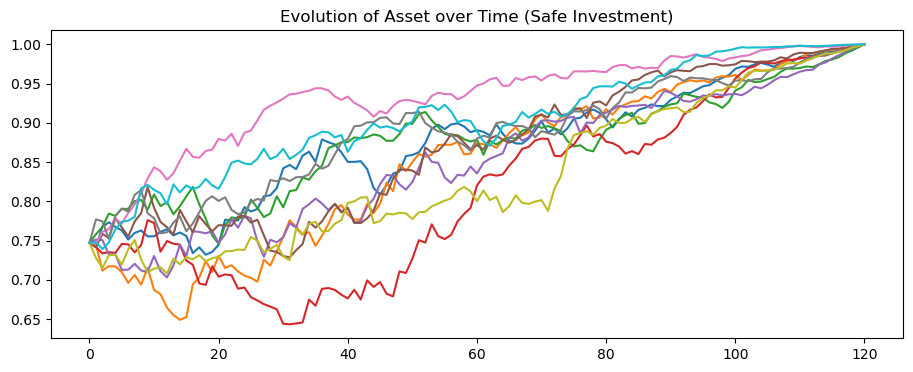

In [9]:
zc_p = zcbp(sim_length, n_paths, a, rbar, sigma, freq, plots = "OFF")
safe_inv = b_0*zc_p
safe_inv.plot(title = 'Evolution of Asset over Time (Safe Investment)', legend = False, figsize = (11,4))

<Axes: title={'center': 'Returns of Safe Invetsment'}>

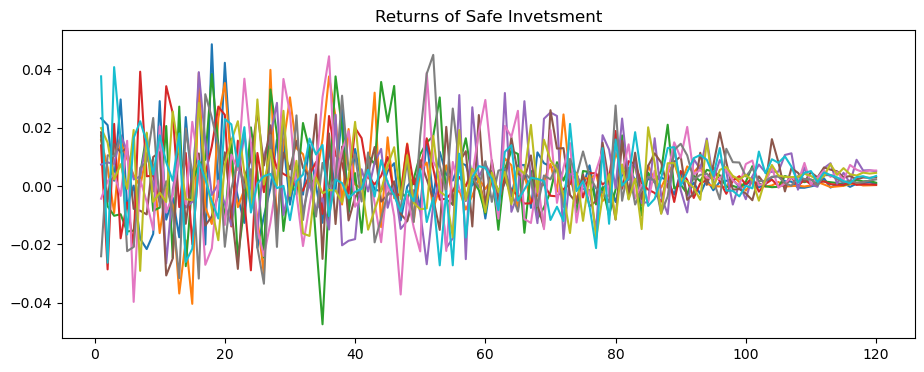

In [29]:
safe_inv.pct_change().plot(title = 'Returns of Safe Invetsment', legend = False, figsize = (11,4))

<Axes: title={'center': 'Evolution of Asset over Time (Rsiky Investment)'}>

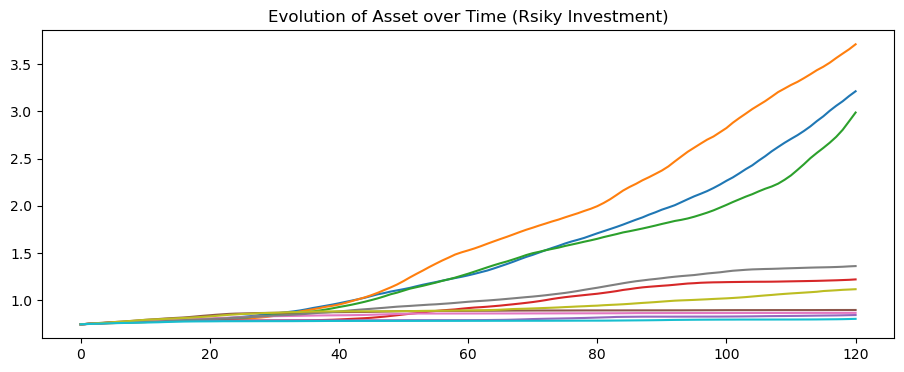

In [9]:
# Ambitious Strategy: risky asset similar to SP500 
a_0        = 0.7441
sim_length = 10
n_paths    = 10
a          = 0.05
rbar       = 0.05
sigma      = 0.16
freq       = 12


annual_r, inst_r = cir(sim_length, n_paths, a, rbar, sigma, freq)

risky_inv = a_0*(annual_r/12 + 1).cumprod()
risky_inv.plot(title = 'Evolution of Asset over Time (Rsiky Investment)', legend = False, figsize = (11,4))

<Axes: title={'center': 'Returns of Rsiky Invetsment'}>

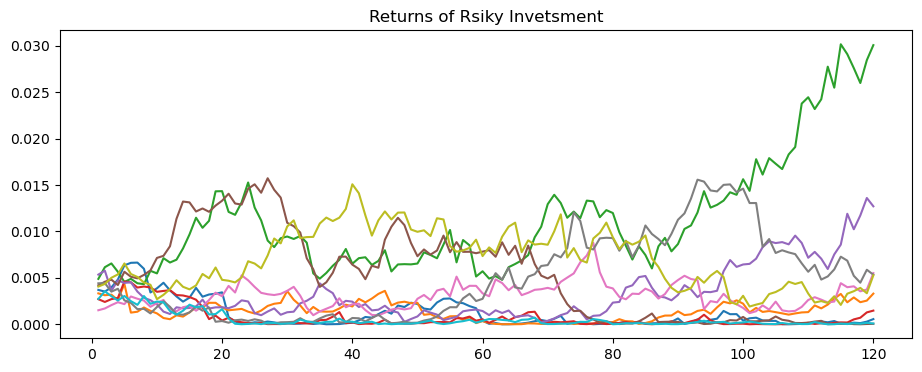

In [31]:
risky_inv.pct_change().plot(title = 'Returns of Rsiky Invetsment', legend = False, figsize = (11,4))

#### Simulation of Terminal Funding Ratio

In [10]:
def fr_sim(sim_length, n_paths, a_b, rbar_b, sigma_b, a_a, rbar_a, sigma_a, freq, plots = "OFF"):
    """
    simulates paths for bond prices and risky assets according to CIR + simulates paths for funding ratio
    
    Inputs
        sim_length : length of simulation in years
        n_paths    : number of simulated paths
        a_b        : mean-reversion speed for short-term rate
        rbar_b     : average long-term annualized short-term rate
        sigma_b    : volatility of short term rate
        a_a        : mean-reversion speed for risky asset
        rbar_a     : average long-term annualized return of risky asset
        sigma_a    : volatility of risky asset
        freq       : frequency of shocks in a year
    
    output
        Simulated paths for funding ratios as a dataframe under two investment strategies (safe and risky)
    """
    
    # evolution of liabilities 
    zc_p = zcbp(sim_length, n_paths, a_b, rbar_b, sigma_b, freq, plots = 'OFF')
    liab = zc_p

    # evolution of assets (safe)
    a_0      = 1.0/((1.0 + rbar_b)**10)             # initial assets to cover liabilities under safe inv. strategy
    p_0      = 1/((1+r_0)**10)
    b_0      = a_0/p_0                              # b_0 is always equal to 1!
    safe_inv = b_0*zc_p
    
   # evolution of assets (risky)
    annual_r, inst_r = cir(sim_length, n_paths, a_a, rbar_a, sigma_a, freq)
    risky_inv        = a_0*(annual_r/12 + 1).cumprod()

    
    if plots == "ON":
        # plot evolution of FR
        (risky_inv/liab).plot(title = 'Evolution of Funding Ratio (Risky Investment))', legend = False, figsize = (11,4))
        (safe_inv/liab).plot(title='Funding Ratio over Time (Safe Investment)', legend=False, figsize=(11,4))
    
    
    # histogram of terminal FR
    tfr_safe  = safe_inv.iloc[-1]/liab.iloc[-1]
    tfr_risky = risky_inv.iloc[-1]/liab.iloc[-1]
    
    tfr_min  = round(tfr_risky.min(), 2)
    tfr_max  = round(tfr_risky.max(), 2)
    tfr_mean = round(tfr_risky.mean(), 2)
    n_fail   = round(tfr_risky[tfr_risky<1].count()/n_paths*100, 2)
    tfr_risky[tfr_risky>4.0] = 4.0
    
    fig = plt.figure(figsize = (11, 5))
    plt.hist(tfr_risky, bins=100, color = "darkred", alpha = 0.75, edgecolor="black", label = "Rsiky Investment")
    plt.axvline(x = 1, linestyle = 'dashed', color = 'blue', linewidth = 4, label = "Safe Investment")
    plt.title ("Terminal Funding Ratio", fontsize = 18)
    plt.annotate(f"Failure : %{n_fail}", xy = (0.70, 0.75), xycoords = 'axes fraction', fontsize=12)
    plt.annotate(f"Mean   : {tfr_mean}", xy = (0.70, 0.70), xycoords = 'axes fraction', fontsize=12)
    plt.annotate(f"Min      : {tfr_min}", xy = (0.70, 0.65), xycoords = 'axes fraction', fontsize=12)
    plt.annotate(f"Max     : {tfr_max}",  xy = (0.70, 0.60), xycoords = 'axes fraction', fontsize=12)

    plt.legend()
    plt.show()


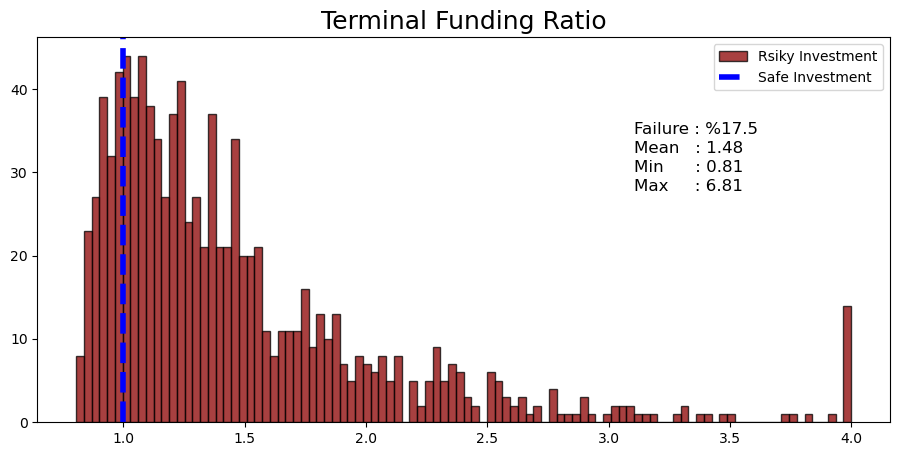

In [11]:
sim_length = 10
n_paths = 1000
a_b = 0.05
rbar_b = 0.03
sigma_b = 0.06
a_a     = 0.03
rbar_a  = 0.06
sigma_a = 0.08
freq = 12

fr_sim(sim_length, n_paths, a_b, rbar_b, sigma_b, a_a, rbar_a, sigma_a, freq)

In [16]:
# interactive simulation
sty = {'description_width': '185px'}
lay = Layout(width='40%', height='20px')

fr_sim_int = ipywidgets.interact(fr_sim,
                               sim_length  = ipywidgets.IntSlider(  value = 10,
                                                                    min   = 3,
                                                                    max   = 12,
                                                                    step  = 1,
                                                                    style = sty,
                                                                   layout = lay,
                                                              description = 'Simulation length:'),
                                 
                               n_paths     = ipywidgets.IntSlider(  value = 1000,
                                                                    min   = 500,
                                                                    max   = 10000,
                                                                    step  = 500,
                                                                    style = sty,
                                                                   layout = lay,
                                                              description = 'Number of paths :'), 
                                 
                               a_b         = ipywidgets.FloatSlider(value = 0.05,
                                                                    min   = 0.01,
                                                                    max   = 0.10,
                                                                    step  = 0.01,
                                                                    style = sty,
                                                                   layout = lay,
                                                              description = 'Mean Reversion (inst. rate) :'),
                                 
                               rbar_b      = ipywidgets.FloatSlider(value = 0.03,
                                                                    min   = 0.01,
                                                                    max   = 0.06,
                                                                    step  = 0.01,
                                                                    style = sty,
                                                                   layout = lay,
                                                              description = 'average return (inst. rate) :'),
                                 
                               sigma_b     = ipywidgets.FloatSlider(value = 0.06,
                                                                    min   = 0.01,
                                                                    max   = 0.12,
                                                                    step  = 0.01,
                                                                    style = sty,
                                                                   layout = lay,
                                                              description = 'Volatility (inst. rate) :'),
                                 
                              a_a         = ipywidgets.FloatSlider(value = 0.05,
                                                                    min   = 0.01,
                                                                    max   = 0.10,
                                                                    step  = 0.01,
                                                                    style = sty,
                                                                   layout = lay,
                                                              description = 'Mean Reversion (risky asset) :'),
                                 
                               rbar_a      = ipywidgets.FloatSlider(value = 0.05,
                                                                    min   = 0.01,
                                                                    max   = 0.15,
                                                                    step  = 0.01,
                                                                    style = sty,
                                                                   layout = lay,
                                                              description = 'average return (risky asset) :'),
                                 
                               sigma_a     = ipywidgets.FloatSlider(value = 0.10,
                                                                    min   = 0.01,
                                                                    max   = 0.25,
                                                                    step  = 0.01,
                                                                    style = sty,
                                                                   layout = lay,
                                                              description = 'Volatility (risky asset) :'),
                                 
                               freq        =  ipywidgets.fixed(12),
                                 
                               plots       = ipywidgets.RadioButtons(options     = ['OFF', 'ON'],
                                                                     description = 'Plot option', 
                                                                     disabled    = False)
                                )

display(fr_sim_int)

interactive(children=(IntSlider(value=10, description='Simulation length:', layout=Layout(height='20px', width…

<function __main__.fr_sim(sim_length, n_paths, a_b, rbar_b, sigma_b, a_a, rbar_a, sigma_a, freq, plots='OFF')>

##  Liability-Driven Investment  <a id="2"></a> 

It is now evident that future liabilities can impose substantial risk. In this simulation, I made two critical assumptions:

1. I assumed that our initial funds are enough to fund our debt. This is not necessarilty the case in reality.

2. As the safe asset, I used zero-coupon bonds that perfectly match the fluctuations of our liabilities. This may not be feasible in reality. In fact, even bonds that match the due dates of our liabilities may not be available in the market. 

In short, if we are initially underfunded, or if we intend to gain profit, then investing in risky assets is inevitable. On the other hand, if bonds that match the duration of our liabilities are not available, we need to construct a portfolio of bonds that matchs the date and the nominal value of our liabilities. In the next simulation exercise, I demonstrate these two concepts.



### Performance Seeking Portfolio (PSP) vs. Liability Hedging Portfolio (LHP) <a id="2.1"></a> 


Generally speaking, an investor could have two potentially conflicting objectives:

* *risk-hedging*: to make sure that an investor is able to meet its future financial needs, we need to construct a  `Liability-Hedging Portfolios (LHP)` whose aim is to ensure that the payoffs match future liabilities.

* *profit gains*: this nature objective requires taking more risk. To achieve this goal, we should build a `Performance-Seeking Portfolio (PSP)` where the objective is to maximize the Sharpe ratio.

These two motives, though conflicting, are not mutually exclusive. In fact, if our initial funding ratio is less than one, then we must gain some return to make-up graounds over time. However, it is difficult to build a portfolio that achieves both goals fairly well simultanously.

To solve this dilemma, consider the optimization problem of an investor who wants to maximize his/her *expected* funding ratio over time:

$$
\max \mathbb{E}\Bigg[u\Big(\frac{Asset_t}{Liab_t}\Big)\Bigg]
$$

The optimal solution to this problem, clearly depends on his/her utility function. However, we can assume that it is possible to build the `LHP` and `PSP` portfolios independently. Let $w_{PSP}$ and $w_{LHP}$, respectively, denote the weight of each asset in each of these two portfolios. Assuming a standard CRRA utility function, we can show that the optimal solution to this problem can be represented as a linear combinations of these two weights: 

$$
w^* = \frac{\lambda_{PSP}}{\gamma \sigma_{PSP}} w_{PSP} + \beta_{L,LHP}\Big(1-\frac{1}{\gamma}\Big) w_{LHP}
$$

where
 * $\gamma$: risk-aversion of the investor
 * $\lambda_{PSP}$: Sharpe ratio of PSP
 * $\sigma_{PSP}$: volatility of PSP,
 
 and,
 
 * $\beta_{L,LHP} = \frac{Cov(Liab, LHP)}{Var(LHP)}$ is the correlation of liabilities with the LHP Portfolio.

Since `PSP` is basically the `MSR` portfolio, which I have explored in a different notebook, in this simulation, I am going to focus on building a LHP portfolio. The key to a successful hedging strategy is to find or construct a set of zero coupon bonds that match our liabilities *in duration*, and gaurantee a return at maturity *similar* to a zero-coupon bond. I starrt by analyzing a `oupon-paying bond`. Such bonds pay regular coupons until maturity, and at maturity both the principal and the final coupon are paid. We price bonds based on the present value of the sequence of the cash flows that they generate. I assume that:
1. bonds pay a monthly constant coupon.
2. the interest rate is constant over the planning horizon (flat yield curve).

This next function, computes the cashflow of a bond:

In [17]:
def cf_construct(maturity, principal, coupon_rate, freq):
    """
    construct a sequence of cash-flows
    
    Inputs
        maturity    : bond maturity in years
        principal   : principal of the bond
        coupon_rate : interest paid on principle annually
        freq        : frequency of payments in a year

    Output
        A series of cash flows indexed by their payment order
    """
    
    n_pays    = round(maturity * freq)
    coupon    = principal * coupon_rate/freq
    order     = np.arange(1, n_pays + 1)
    cash_flow = pd.Series(data = coupon, index = order)
    
    cash_flow.iloc[-1] = cash_flow.iloc[-1] + principal    # last payment: the principal + last coupon
    return cash_flow


In [18]:
maturity    = 10
principal   = 100
coupon_rate = 0.03
freq        = 12
cf_construct(10, 100, 0.03, 12)

1        0.25
2        0.25
3        0.25
4        0.25
5        0.25
        ...  
116      0.25
117      0.25
118      0.25
119      0.25
120    100.25
Length: 120, dtype: float64

In [19]:
def disc_cf(maturity, principal, coupon_rate, freq, disc_rate):
    """
    computes discounted casf flow of a bond as a series
    
    Inputs
        maturity    : bond maturity in years
        principal   : principal of the bond
        coupon_rate : interest paid on principle annually
        freq        : frequency of payments in a year
        disc_rate   : interest rate to be used as a discount rate
        
    Output
        A series of cash flows indexed by their payment order 
    """
    cash_flow = cf_construct(maturity, principal, coupon_rate, freq)
    disct_fac = (1 + disc_rate/freq)**(-cash_flow.index)
    
    return pd.Series(data = disct_fac * cash_flow, index = cash_flow.index)

In [20]:
def bond_price(maturity, principal, coupon_rate, freq, disc_rate):
    """
    computes bond price based on its casf flow
    
    Inputs
        maturity    : bond maturity in years
        principal   : principal of the bond
        coupon_rate : interest paid on principle annually
        freq        : frequency of payments in a year
        disc_rate   : interest rate to be used as a discount rate
        
    Output
        price of bond 
    """
    cash_flow = cf_construct(maturity, principal, coupon_rate, freq)
    bond_p    = present_value(cash_flow, disc_rate/freq)
    return bond_p


In [21]:
bond_price(10, 100, 0.04, 4, .03)

108.61173461000779

### Duration-Matching Bond Portfolios  <a id="2.2"></a>

The key to building a LHP portfolio is to be able to combine various bonds with different coupon structures in a way that it replicates the behavior of our liability. A first step towards that goal is to be able to understand the `effective` duration of a bond. Although, every bond has a nominal maturity, a better metric is the so-called `Macaulay duration`. The Macaulay duration, bascially, is the weighted average of all the cash flows that a bond generates where the weight of each cash flow is the ratio of the present value of the cash flow to the bond price:

$$
D_M = \frac{\sum\limits_{i = 1}^{N} \frac{i}{(1+r)^i} \times CF_i }{\sum\limits_{i = 1}^{N} \frac{1}{(1+r)^i} \times CF_i }
$$
where
* $i$: payment order
* $N$: maturity date
* $r$: interest rate/discount factor
* $CF_i$: i-th cash flow generated by bond 


In essence, this is the weighted average number of periods you have to be invested in the bond to get the present value of the bond back where the weight is given by the present value of the cahs flows. This is an important metric which depends on both the *maturiy* and the *interest rate*. This effective duration combines all relevant information and provides a number in time units that can be used to match our liabilities. 

Consider a bond with `principle = 100 USD`, which has a maturity of `2 years` and a coupon rate of `4 percent` that is paid `quarterly`: 

In [22]:
def macaulay_duration(cf, freq, disc_rate):
    """
    Inputs
        cf        : cash flow as an indexed series
        disc_rate : interest rate to be used as a discount rate
        
    Output
        the Macaulay Duration of this bond in years
    """
    disct_cf = ((1 + disc_rate/freq)**(-cf.index))*cf

    return ((cf.index*disct_cf).sum()/disct_cf.sum())/freq

In [23]:
cf = cf_construct(2, 100, 0.04, 4)

print("The effective duration of our liabilities: ", macaulay_duration(cf, 4, 0.04).round(5), " years")

The effective duration of our liabilities:  1.93205  years


Now that we have introduced this notion, we construct a portfolio of bonds that match our liabilities. 
Consider an arbitrary liability structure of `100 USD` in `8 years` and another `100 USD` in `10 years`. Assume that the interest rate is constant and equal to `3 percent`, and payments are made annually. 

In [24]:
liab = pd.Series(data = [100, 100], index=[8, 10])
d_l  = macaulay_duration(liab, 1, 0.03)
print("The effective duration of our liabilities: ", d_l.round(5), " years")

The effective duration of our liabilities:  8.97045  years


If we had access to a zero coupon bond with the same duration, then we could hedge using that. Since, we assume that is not available, we should construct a portfolio from the available bonds. Let's assume that two types of bonds are available:

1. A bond with the face value of `10 USD` that pays a `5 percent` coupon `once a year`, and matures in `9 year`.
2. A bond with the face value of `10 USD` that pays a `4 percent` coupon `once a year`, and matures in `12 years`.


Assume that the interest rate is `3 percent`. 

In [25]:
# fisrt bond
cf_1 = cf_construct(9, 10, 0.05, 1)
d_1  = macaulay_duration(cf_1, 1, 0.03)


print("The effective duration of first bond: ", d_1.round(5), " years")
print("")
print("Note: coupon rate > interest rate ----> smaller durations")

The effective duration of first bond:  7.5863  years

Note: coupon rate > interest rate ----> smaller durations


In [26]:
# second bond
cf_2 = cf_construct(12, 10, 0.04, 1)
d_2  = macaulay_duration(cf_1, 1, 0.03)


print("The effective duration of second bond: ", d_2.round(5), " years")

The effective duration of second bond:  7.5863  years


We need a portfolio of these two bonds that has a combined target duration that matches the duration of the liability:

$$ w_1 \times d_1 + w_2 \times d_2 = d_l $$

where 
* $w_1:$ weight of first bond in our portfolio
* $d_1:$ duration of first bond 
* $w_2:$ weight of second bond in our portfolio
* $d_2:$ duration of second bond  
* $d_l:$ duration of liabilities


In this specific example, 

$$ w_1 \times 7.58 + (1-w_1) \times 9.88 = 8.97 \hspace{5mm} \rightarrow \hspace{5mm} w_1 = \frac{9.88 - 8.97}{9.88 - 7.58} = 0.395$$


Then, we can construct the following portfolio:

$$\Bigg\{ {\frac{w_1 * a_0}{p_1}\text{  units of first bond }, \hspace{3mm}\frac{(1-w_1) * a_0}{p_2} \text{  units of second bond}}\Bigg\}$$

where 
* $a_0:$ initial assets
* $p_1:$ price of bond 1
* $p_2:$ price of bond 2

This portfolio will match the duration of our liabilities. The following function computes the matching weights:

In [27]:
def matching_weights(cf_1, cf_2, cf_l, fr_1, fr_2, fr_l, disc_rate):
    """
    Computes the matching weights of the First bond
    
    Inputs
        cf_1      : inddexed cash flow of first bond (short maturity)
        cf_2      : inddexed cash flow of second bond (long maturity)
        cf_l      : inddexed cash flow of liabilities
        fr_1      : frequency of coupon for first bond
        fr_2      : frequency of coupon for second bond
        fr_l      : frequency of payment for liabilities
        disc_rate : interest rate to be used as a discount rate
    
    Returns 
        weight of bond 1 to match the effective duration of given liabilities
    """
    d_1 = macaulay_duration(cf_1, fr_1, disc_rate)
    d_2 = macaulay_duration(cf_2, fr_2, disc_rate)
    d_l = macaulay_duration(cf_l, fr_l, disc_rate)
    
    return (d_2 - d_l)/(d_2 - d_1)

Here, I am assuming that our initial assets are \\$ 150; *i.e.,* we are underfunded to begin with! Since we have assumed coupn rates that are higher than the interest rate, this should help us make up ground over time.

In [28]:
p_1 = bond_price(9, 10, 0.05, 1, 0.03)
p_2 = bond_price(12, 10, 0.04, 1, 0.03)
a_0 = 150
w_1 = matching_weights(cf_1, cf_2, liab, 1 , 1, 1, 0.03)

print(" Duration Matching Portfolio:")
print("=================================================================")
print('{:18s}{:15s}{:18s}'.format("", "Price", "Number of Units"))
print('{:17s}{:.4f}{:13.5s}{:.4f}'.format("First bond : ", p_1.round(4) , "", (a_0*w_1/p_1).round(3)))
print('{:17s}{:.4f}{:13.5s}{:.4f}'.format("Second bond: ", p_2.round(3) , "", (a_0*(1-w_1)/p_2).round(3)))

 Characteristics of the Duration Matching Portfolio:
                  Price          Number of Units   
First bond :     11.5572             5.1500
Second bond:     10.9950             8.2290


This is the portfolio that matches, in duration, our liabilities. Let's verify that:

In [34]:
# cashflow generated by first bond
dmp_cf1 = (a_0*w_1/p_1) * cf_1

# cashflow generated by second bond
dmp_cf2 = (a_0*(1-w_1)/p_2) * cf_2

# cash flow of dmp
dmp_cf  = (dmp_cf1 + dmp_cf2).fillna(dmp_cf1).fillna(dmp_cf2) # two cash flows have different lengths!

In [39]:
print(" Effective duration of liabilities    : ", d_l.round(5), " years")
print(" Effective duration of bond portfolio : ", macaulay_duration(dmp_cf, 1, 0.03).round(5), " years")

 Effective duration of liabilities    :  8.97045  years
 Effective duration of bond portfolio :  8.97045  years


#### Duration-matching Bond Portfolio: Another Look <a id="2.2.1"></a>
An alternative approach to understanding the duration-matching portfolio is to examine the present value of all relevant cash flows. In this example, there are four cash flows:
1) cash flow of liabilities
2) cash flow of first (short) bond
3) cash flow of second (long) bond
4) cash flow of duration-matching bond portfolio

It is important to note that the cash flow of a duration-matching bond portfolio is simply a `linear combination` of the cash flows of the underlying bonds with the computed weights.

As we defined earlier, the ratio of the present value of assets to the present value of liabilities is considered funding ratio. The next figure examines the evolution of this funding ratio under three scenarios:
* full investment in first bond
* full investment in second bond
* duration-matching bond portfolio


In [42]:
def pv_fr(cf_a, cf_l, r):
    """
    Computes Funding Ratio as the ratio between the present value of assets and liabilities
    
    Inputs
        cf_a : cash flow of assets
        cf_l : cash flow of liabilities
        r    : interest rate
    
    Output
        the funding ratio
    """
    return present_value(cf_a, r)/present_value(cf_l, r)

In [53]:
print("The Ratio between the Present Value of Assets and Liabilities:")
print("===================================================================")

print('{:17s}{:.4f}'.format("Full Investment in First Bond     : ", pv_fr(cf_1*(a_0/p_1), liab, 0.03).round(4)))
print('{:17s}{:.4f}'.format("Full Investment in Second Bond    : ", pv_fr(cf_2*(a_0/p_2), liab, 0.03).round(4)))
print('{:17s}{:.4f}'.format("Duration-matching Bond Portfolio  : ", pv_fr(dmp_cf, liab, 0.03).round(4)))

The Ratio between the Present Value of Assets and Liabilities:
Full Investment in First Bond     : 0.9782
Full Investment in Second Bond    : 0.9782
Duration-matching Bond Portfolio  : 0.9782


All lead to the same number. Why?

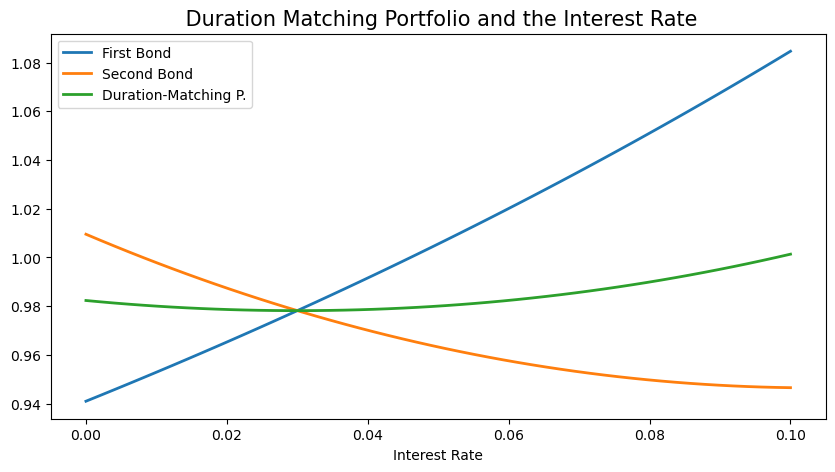

In [58]:
rate    = np.linspace(0.00, 0.10, 50)
fr_evol = pd.DataFrame(columns = ["Rates", "B-1", "B-2", "DMP"], index = np.arange(len(rate))) 
fr_evol["Rates"] = rate

for i in np.arange(len(rate)):
    rnow = fr_evol.loc[i, "Rates"]
    
    fr_evol.loc[i, "B-1"] = pv_fr(cf_1*(a_0/p_1), liab, rnow )
    fr_evol.loc[i, "B-2"] = pv_fr(cf_2*(a_0/p_2), liab, rnow )
    fr_evol.loc[i, "DMP"] = pv_fr(dmp_cf, liab, rnow )

# alternatively
# fr_evol = pd.DataFrame({
#     "Bond-1":[rm.funding_ratio2(b1_port, liabilities, r) for r in rates],
# }, index=rates)

plt.figure(figsize = (10,5)) 
plt.plot(fr_evol["Rates"], fr_evol["B-1"], label = "First Bond", linewidth = 2)
plt.plot(fr_evol["Rates"], fr_evol["B-2"], label = "Second Bond", linewidth = 2)
plt.plot(fr_evol["Rates"], fr_evol["DMP"], label = "Duration-Matching P.", linewidth = 2)

plt.xlabel('Interest Rate')
plt.title(' Duration Matching Portfolio and the Interest Rate', fontsize = 15)
plt.legend()


plt.show()


This shows that:
1) Short bond performs better if interest rates rise.
2) Long bond performs better if interest rates fall.
3) Duration matching bond portfolio:
    * keeps the funding ratio between the two bonds.
    * keeps the funding ratio closer to 1.

4) At the given interest rate, the duration-matching bond portfolio is at the intersection of the two other paths. 

### Asset Allocation: A Simulation  <a id="2.3"></a>

The last section of this notebook studies the allocation of assets between a `PSP` and a `LHP` portfolio. To do this simulation, I start by simulating the fluctuations of the interest rate according to the CIR model. 


In [64]:
# paths for interest rate 
sim_length = 10
n_paths    = 200
a          = 0.05
rbar       = 0.03
sigma      = 0.06
freq       = 12


annual_r, inst_r = cir(sim_length, n_paths, a, rbar, sigma, freq)

#### Coupon-Bearing Bonds  <a id="2.3.1"></a>

Then, I simulate the performance of a coupon-bearing bond under various interest rate scenarios. A coupon-paying bond, in essence, is a sequence of cash flows. However, this cash flow has different present values depending on the interest rate. Therefore, the price of a coupon-bearing bond, requires computing *the present value* of the **remaining cash flows**, given the **interest rate** at that time. 

I assume that the bond has a maturity of `10 years`, its principal is `100 USD`, and pays a `constatnt` coupon `each month` at the annual rate of `4 percent`.

In [62]:
# Coupon-bearing bond price
def cbbp(rates, maturity, principal, coupon_rate, freq):
    """
    Computes the price of a coupon-bearing bond over each simulated path for short term rate
    
    Inputs
        rates         : a dataframe of simulated short term interest rates
        maturity      : bodn maturity in years
        principal     : bond principal
        coupon_rate   : copoun rate of the bond
        freq          : freqeuncy of coupon payments in a year
    
    output:
        a dataframe of prices under each path for the short term rate
    """

    bondp = pd.DataFrame().reindex_like(rates)

    for i in bondp.index:
        for j in bondp:
            if maturity - i/freq <= 0:
                bondp.loc[i,j] = principal + principal*coupon_rate/freq        
            else:
                bondp.loc[i,j] = bond_price(maturity - i/freq, principal, coupon_rate, freq, rates.loc[i,j])

    return bondp

Text(0.5, 0, 'Period')

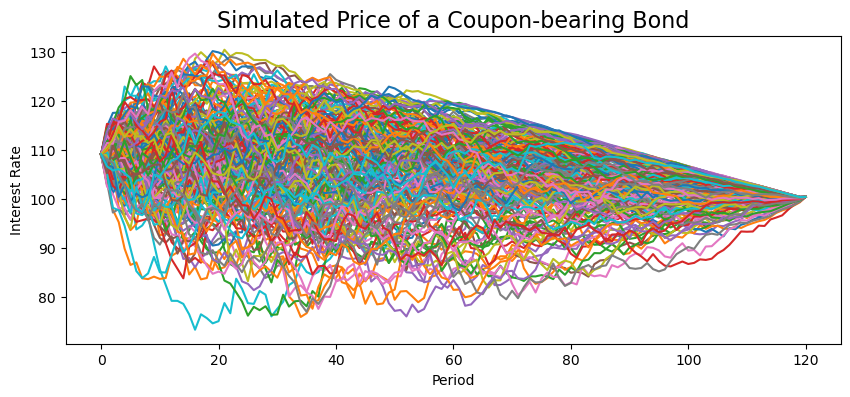

In [81]:
maturity    = 10
principal   = 100
coupon_rate = 0.04 
freq        = 12

# simulated prices
cbb_p =  cbbp(inst_r, maturity, principal, coupon_rate, freq)

# plot
fig = plt.figure(figsize = (10, 4))
plt.plot(cbb_p)
plt.title ("Simulated Price of a Coupon-bearing Bond", fontsize = 16)
plt.ylabel('Interest Rate')
plt.xlabel('Period')

In [92]:
print('Initial bond price in simulation  :  ', cbb_p.iloc[0,0].round(3))
print('Maximum bond price in simulation  :  ', round(max(cbb_p.max(axis = 1)),3))
print('Minimum bond price in simulation  :  ', round(min(cbb_p.min(axis = 1)),3))
print('Final   bond price in simulation  :  ', cbb_p.iloc[-1,0].round(3))

Initial bond price in simulation  :   109.03
Maximum bond price in simulation  :   130.368
Minimum bond price in simulation  :   73.222
Final   bond price in simulation  :   100.333


Now, let's compute returns on this bond on each path. The monthly return of a bond is, by definition,

$$
r^m_t = \frac{p_t + c_t}{p_{t-1}}
$$

where $c_t$ is the coupon payment in month $t$. 

In [116]:
def cbb_return(bond_p, principal, coupon_rate, freq):
    
    """
    Computes the return of a coupon-bearing bond over each simulated path for short term rate
    
    Inputs
        bond_p        : a dataframe of simulated bond prices
        principal     : bond principal
        coupon_rate   : copoun rate of the bond
        freq          : freqeuncy of coupon payments in a year
    
    output:
         annualized return of bond on each price path
    """
    
    coupon   = principal*coupon_rate/freq
    b_rets_s = pd.DataFrame().reindex_like(bond_p)           # dataframe for returns
    b_rets_a = pd.DataFrame().reindex_like(bond_p)           # dataframe for annualized returns

    
    for i in range(1, len(bond_p.index)):
        for j in b_rets_s.columns:           
            b_rets_s.loc[i,j] = (bond_p.loc[i,j] + coupon)/bond_p.loc[i-1,j] - 1
            
    compound = (1 + b_rets_s).prod()
    b_rets_a = compound**(freq/b_rets_s.shape[0])-1

    return b_rets_a
            

In [121]:
bond_ret = cbb_return(cbb_p, principal, coupon_rate, freq)

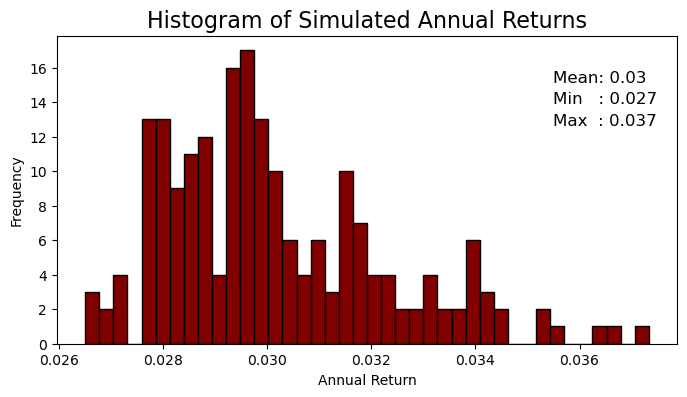

In [125]:
plt.subplots(figsize=(8, 4)) 
plt.title("Histogram of Simulated Annual Returns", fontsize = 16)
plt.ylabel("Frequency")
plt.xlabel("Annual Return")
plt.hist(bond_ret, bins = 40, color = "maroon", edgecolor = "black")
plt.annotate(f"Mean: {round(bond_ret.mean(), 3)}", xy = (.80, .85), xycoords = 'axes fraction', fontsize=12)
plt.annotate(f"Min   : {round(bond_ret.min(), 3)}", xy = (.80, .78), xycoords = 'axes fraction', fontsize=12)
plt.annotate(f"Max  : {round(bond_ret.max(), 3)}", xy = (.80, .71), xycoords = 'axes fraction', fontsize=12)

plt.show() 


#### PSP vs. LHP Allocation  <a id="2.3.2"></a>
Now, we can conduct the final simulation. Consider the following problem:

1) Liabilities: two payments, each for `100 USD` at the end of `year 8` and `year 10`.
2) Short-term rate: follows a CIR model with a long-run average of `3 percent` and volatility of `6 percent`. 
3) Risky asset: follows a brownian motion with annual mean of `6 percent` and annual volatility of `15 percent`. 
4) Short bond: principal of `100 USD`, maturity of `7 years`, monthly coupon payment at rate of `5 percent`
5) Long bond: principal of `100 USD`, maturity of `20 years`, monthly coupon payment at rate of `5 percent`
6) Planning horizon is `10 years`.


**Note:** The long bond will NOT mature when our liabilities are due!

Since the risky asset follows a brownian motion, I am going to use the following code to simulate its price fluctuations:


In [257]:
def return_sim(sim_length, n_paths, mu, sigma):
    """
    Inputs
        sim_length : length of simulation period in years
        n_paths    : number of paths to be simulated
        mu         : annaulized mean
        sigma      : annualized volatility
    
    Output
        simulated prices as a dataframe
    """
 
    n     = int(sim_length*1.0)                  # number of simulations on each path
    dt    = 1.0                                  # time interval between two consequtive simulations on each path
    xi    = np.random.normal(size=(n, n_paths))  # stochastic components of price as a normal random variable
    rx    = mu*dt + sigma*np.sqrt(dt)*xi         # return paths
    rx    = pd.DataFrame(rx)                     # return paths as a dataframe
     
    return rx


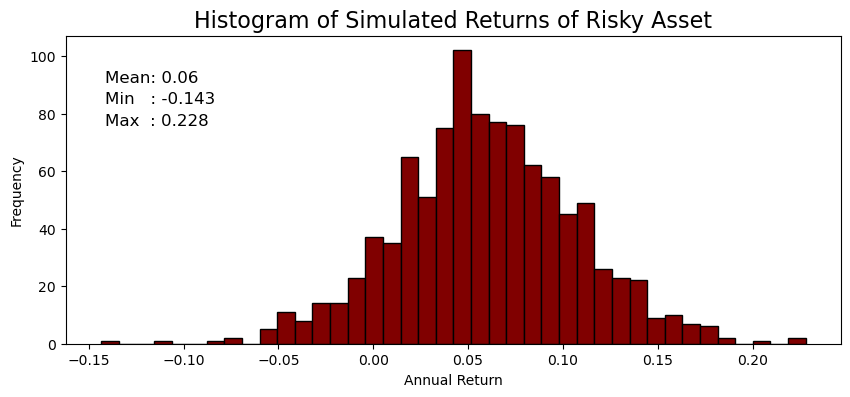

In [268]:
# simulation parameters
sim_length = 10
n_paths    = 1000
freq       = 12

# risky asset
mu          = 0.06
sigma       = 0.15
risky_r    = return_sim(sim_length, n_paths, mu, sigma)
risky_r[0] = mu

plt.subplots(figsize=(10, 4)) 
plt.title("Histogram of Simulated Returns of Risky Asset" , fontsize = 16)
plt.ylabel("Frequency")
plt.xlabel("Annual Return")
plt.hist(risky_r.mean(), bins = 40, color = "maroon", edgecolor = "black")
plt.annotate(f"Mean: {round(risky_r.mean().mean(), 3)}", xy = (.05, .85), xycoords = 'axes fraction', fontsize=12)
plt.annotate(f"Min   : {round(risky_r.mean().min(), 3)}", xy = (.05, .78), xycoords = 'axes fraction', fontsize=12)
plt.annotate(f"Max  : {round(risky_r.mean().max(), 3)}", xy = (.05, .71), xycoords = 'axes fraction', fontsize=12)

plt.show() 

In [269]:
# paths for short-term interest rate 
a          = 0.05
rbar       = 0.03
sigma      = 0.06
freq       = 12

annual_r, inst_r = cir(sim_length, n_paths, a, rbar, sigma, freq)

# liabilities
liab = pd.Series(data = [100, 100], index=[8*12, 10*12])


# short bond
cf_short  = cf_construct(7, 100, 0.05, 12)             # cash flow
bp_short  = cbbp(inst_r, 7, 100, 0.05, 12)             # simulated price paths
short_ret = cbb_return(bp_short, 100, 0.05, 12)        # returns on each simulated price path

# long bond
cf_long  = cf_construct(20, 100, 0.05, 12)            # cash flow
bp_long  = cbbp(inst_r, 20, 100, 0.05, 12)            # simulated price paths
long_ret = cbb_return(bp_long, 100, 0.05, 12)         # returns on each simulated price path


In [140]:
print(" Duration Matching Portfolio:")
print("=========================================")
print('weight of short bond :  ' , matching_weights(cf_short, cf_long, liab, 12 , 12, 12, 0.03).round(3))
print('weight of long  bond :  ' , 1-matching_weights(cf_short, cf_long, liab, 12 , 12, 12, 0.03).round(3))

 Duration Matching Portfolio:
weight of short bond :   0.613
weight of long  bond :   0.387


I assume that a duration-matching portfolio is constructed at the beginning of the simulation. But, these weights are not updated over time. Obviously, this is not an optimal strategy as we could periodically update our portfolio. However, for this simulation the weights are *constant*.

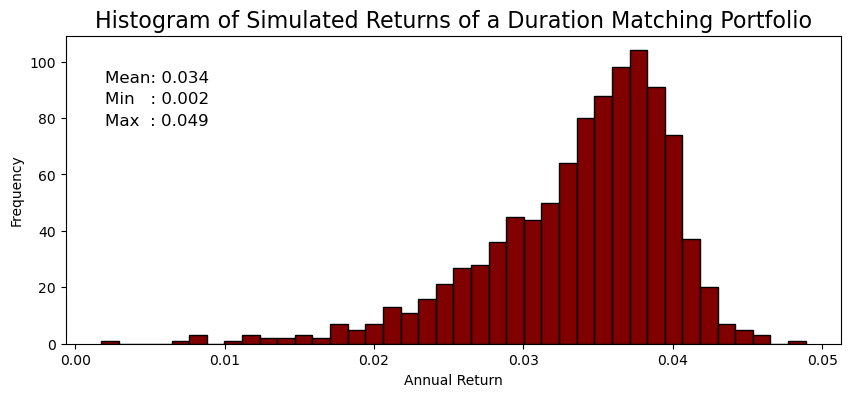

In [145]:
w_1    =  matching_weights(cf_short, cf_long, liab, 12 , 12, 12, 0.03).round(3)
dmp_p  = w_1 * bp_short + (1.0 - w_1) * bp_long
dmp_cf = w_1 * cf_short + (1.0 - w_1) * cf_long
dmp_r  = w_1 * short_ret + (1.0 - w_1) * long_ret


# plot
plt.subplots(figsize=(10, 4)) 
plt.title("Histogram of Simulated Returns of a Duration Matching Portfolio", fontsize = 16)
plt.ylabel("Frequency")
plt.xlabel("Annual Return")
plt.hist(dmp_r, bins = 40, color = "maroon", edgecolor = "black")
plt.annotate(f"Mean: {round(dmp_r.mean(), 3)}", xy = (.05, .85), xycoords = 'axes fraction', fontsize=12)
plt.annotate(f"Min   : {round(dmp_r.min(), 3)}", xy = (.05, .78), xycoords = 'axes fraction', fontsize=12)
plt.annotate(f"Max  : {round(dmp_r.max(), 3)}", xy = (.05, .71), xycoords = 'axes fraction', fontsize=12)

plt.show() 

In practice, the PSP portfolio should maximize the Sharpe ratio. In this simulation, I simply assume that the above risky asset represents our PSP. The last step, then, is to allocate our assets between these two portfolios. This allocation is sometimes critical if we start our programming problem underfunded -*i.e.,* starting funds less than nominal liabilities- as is the case in our example. To determine the optimal allocation between the two, we can use our analytical solution. However, for simulation purposes, I build a portfolio with a fixed split between the PSP and LHP. 

In [307]:
def split_sim(w_psp):
    """
    Plots histograms of LHP, PSP, and the given Split portfolio 
    
    Inputs
        w_psp   : weight split between PSP and LHP
      
    
    output
        Simulated paths for funding ratios as a dataframe under two investment strategies (safe and risky)
    """
    
    split_r = w_psp * psp_ret + (1.0 - w_psp) * lhp_ret
    
    # plots
    x = int(w_psp * 100)
    y = int((1.0 - w_psp) * 100)
    lab = str(x) + "-" + str(y) + " Split"
    fig = plt.figure(figsize = (11, 5))
    sns.histplot(psp_ret, bins = n_bins,  color = "b", edgecolor = "b", kde = "True", alpha = 0.3, label = "PSP")
    sns.histplot(lhp_ret, bins = n_bins , color = "r", edgecolor = "r", kde = "True", alpha = 0.3, label = "LHP")
    sns.histplot(split_r,   bins = n_bins , color = "k", edgecolor = "k", kde = "True", alpha = 0.3, label = lab)
    plt.title("PSP-LHP Split: Returns", fontsize = 18)
    plt.legend()
    plt.show()


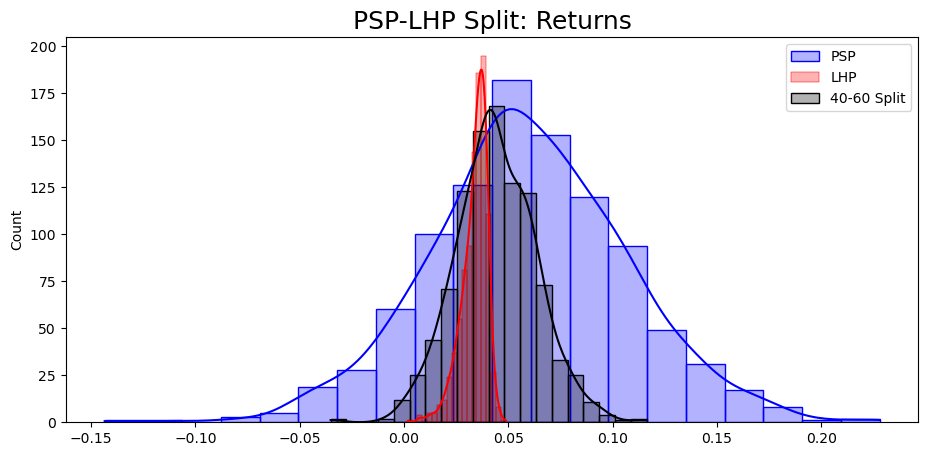

In [308]:
split_sim(0.4)

In [312]:
# interactive simulation

split_sim_int = ipywidgets.interact(split_sim,
                               w_psp  = ipywidgets.FloatSlider(  value = 0.3,
                                                                    min   = 0.01,
                                                                    max   = 0.99,
                                                                    step  = 0.01,
                                                               description = 'Split Weight')                                 
                                   )

display(split_sim_int)

interactive(children=(FloatSlider(value=0.3, description='Split Weight', max=0.99, min=0.01, step=0.01), Outpu…

<function __main__.split_sim(w_psp)>

In [282]:
lhp_ret = dmp_r
psp_ret = risky_r.mean()
weights = 0.40
psp_lhp_1 = weights*psp_ret + (1.0 - weights)*lhp_ret

Text(0.5, 0, 'Annual Return')

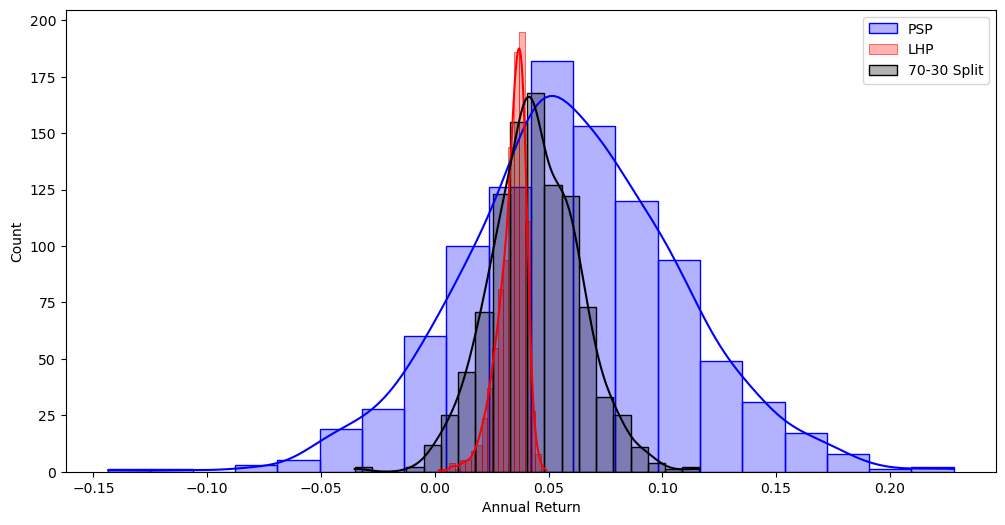

In [283]:
fig = plt.figure(figsize=(12, 6))
n_bins = 20

plt.xlabel("Annual Return")